C:\Users\xrcru\AppData\Local\Temp\ipykernel_36260\4089116874.py:177: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


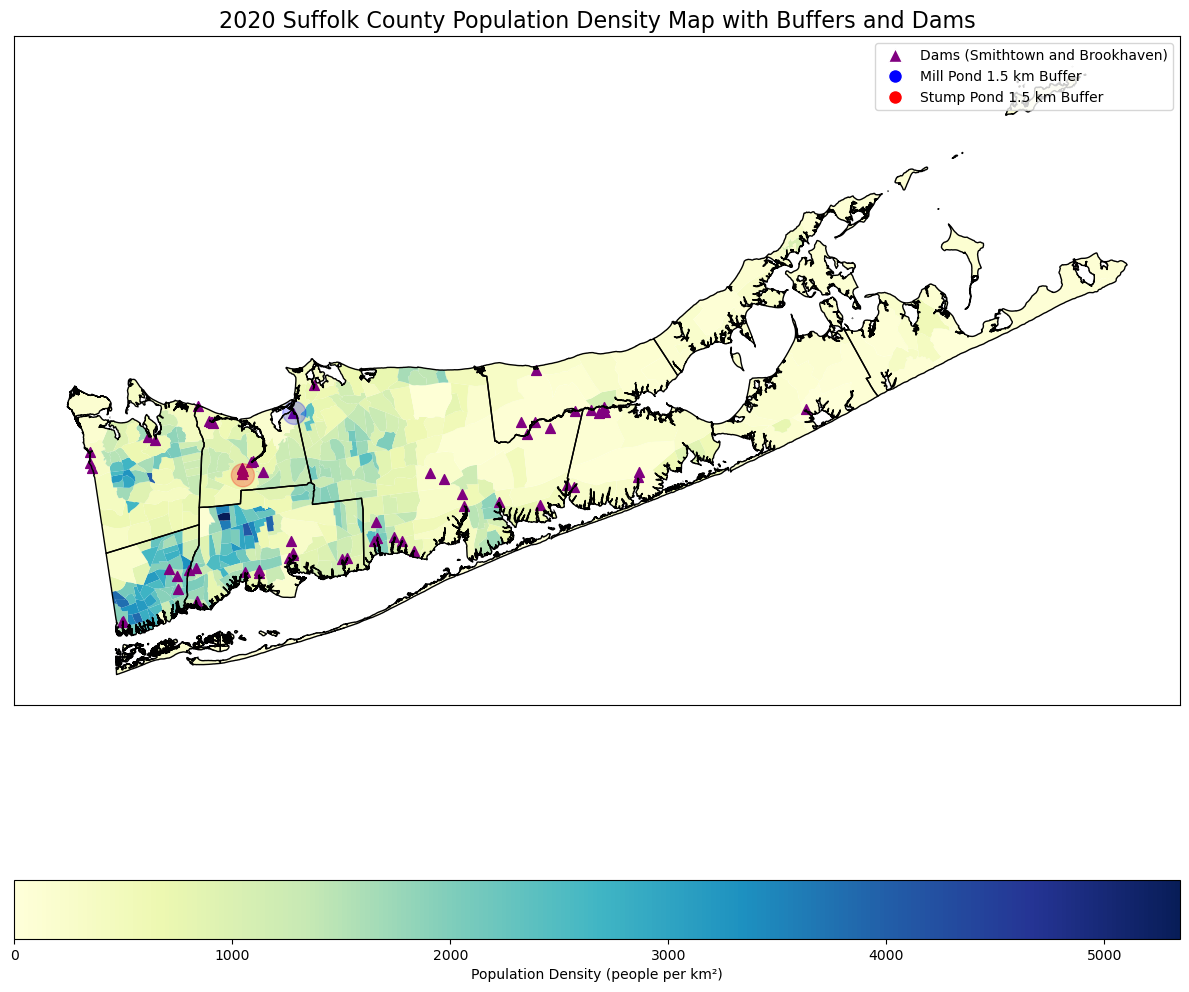

===== Population Buffer Analysis Summary =====
Mill Pond Buffer:
  Total Population: 22417
  Population Density: 3905.94 people/km²

Stump Pond Buffer:
  Total Population: 15952
  Population Density: 2260.38 people/km²


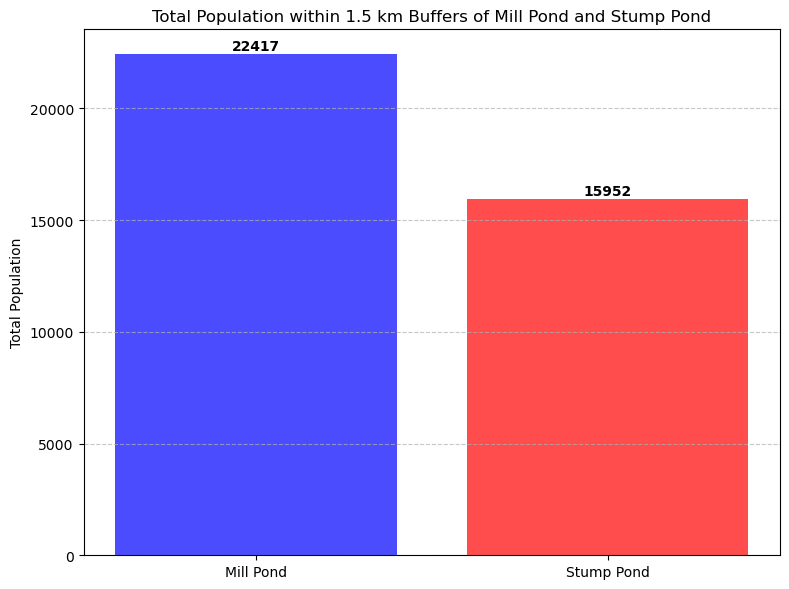

Original CRS of land_use_2016: EPSG:6539
CRS of land_use_2016 after reprojection: EPSG:6538
Mill Pond Land Use Data:
        OBJECTID             PARCELID     ACRES        TOWN  SCLANDUSE  \
370427    370434  0200272000200008000  0.052059  Brookhaven         10   
370425    370432  0200272000200006002  0.897867  Brookhaven          1   
79209      79210  0800040000200016000  0.553736   Smithtown          1   
370426    370433  0200272000200007000  1.672839  Brookhaven         10   
79178      79179  0800040000100007027  1.206545   Smithtown          1   

                     DESCRIPTIO   Shape_Leng    Shape_Area  \
370427           Transportation   289.411328   2267.677914   
370425  Low Density Residential  1098.333189  39110.857723   
79209   Low Density Residential   890.533309  24120.676959   
370426           Transportation  2291.687359  72868.569216   
79178   Low Density Residential   967.758330  52556.856382   

                                                 geometry  
37042

C:\Users\xrcru\AppData\Local\Temp\ipykernel_36260\4089116874.py:359: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0, 0), 1, 1, color=land_use_colors.get(label, 'gray'), edgecolor='black') for label in land_use_colors]


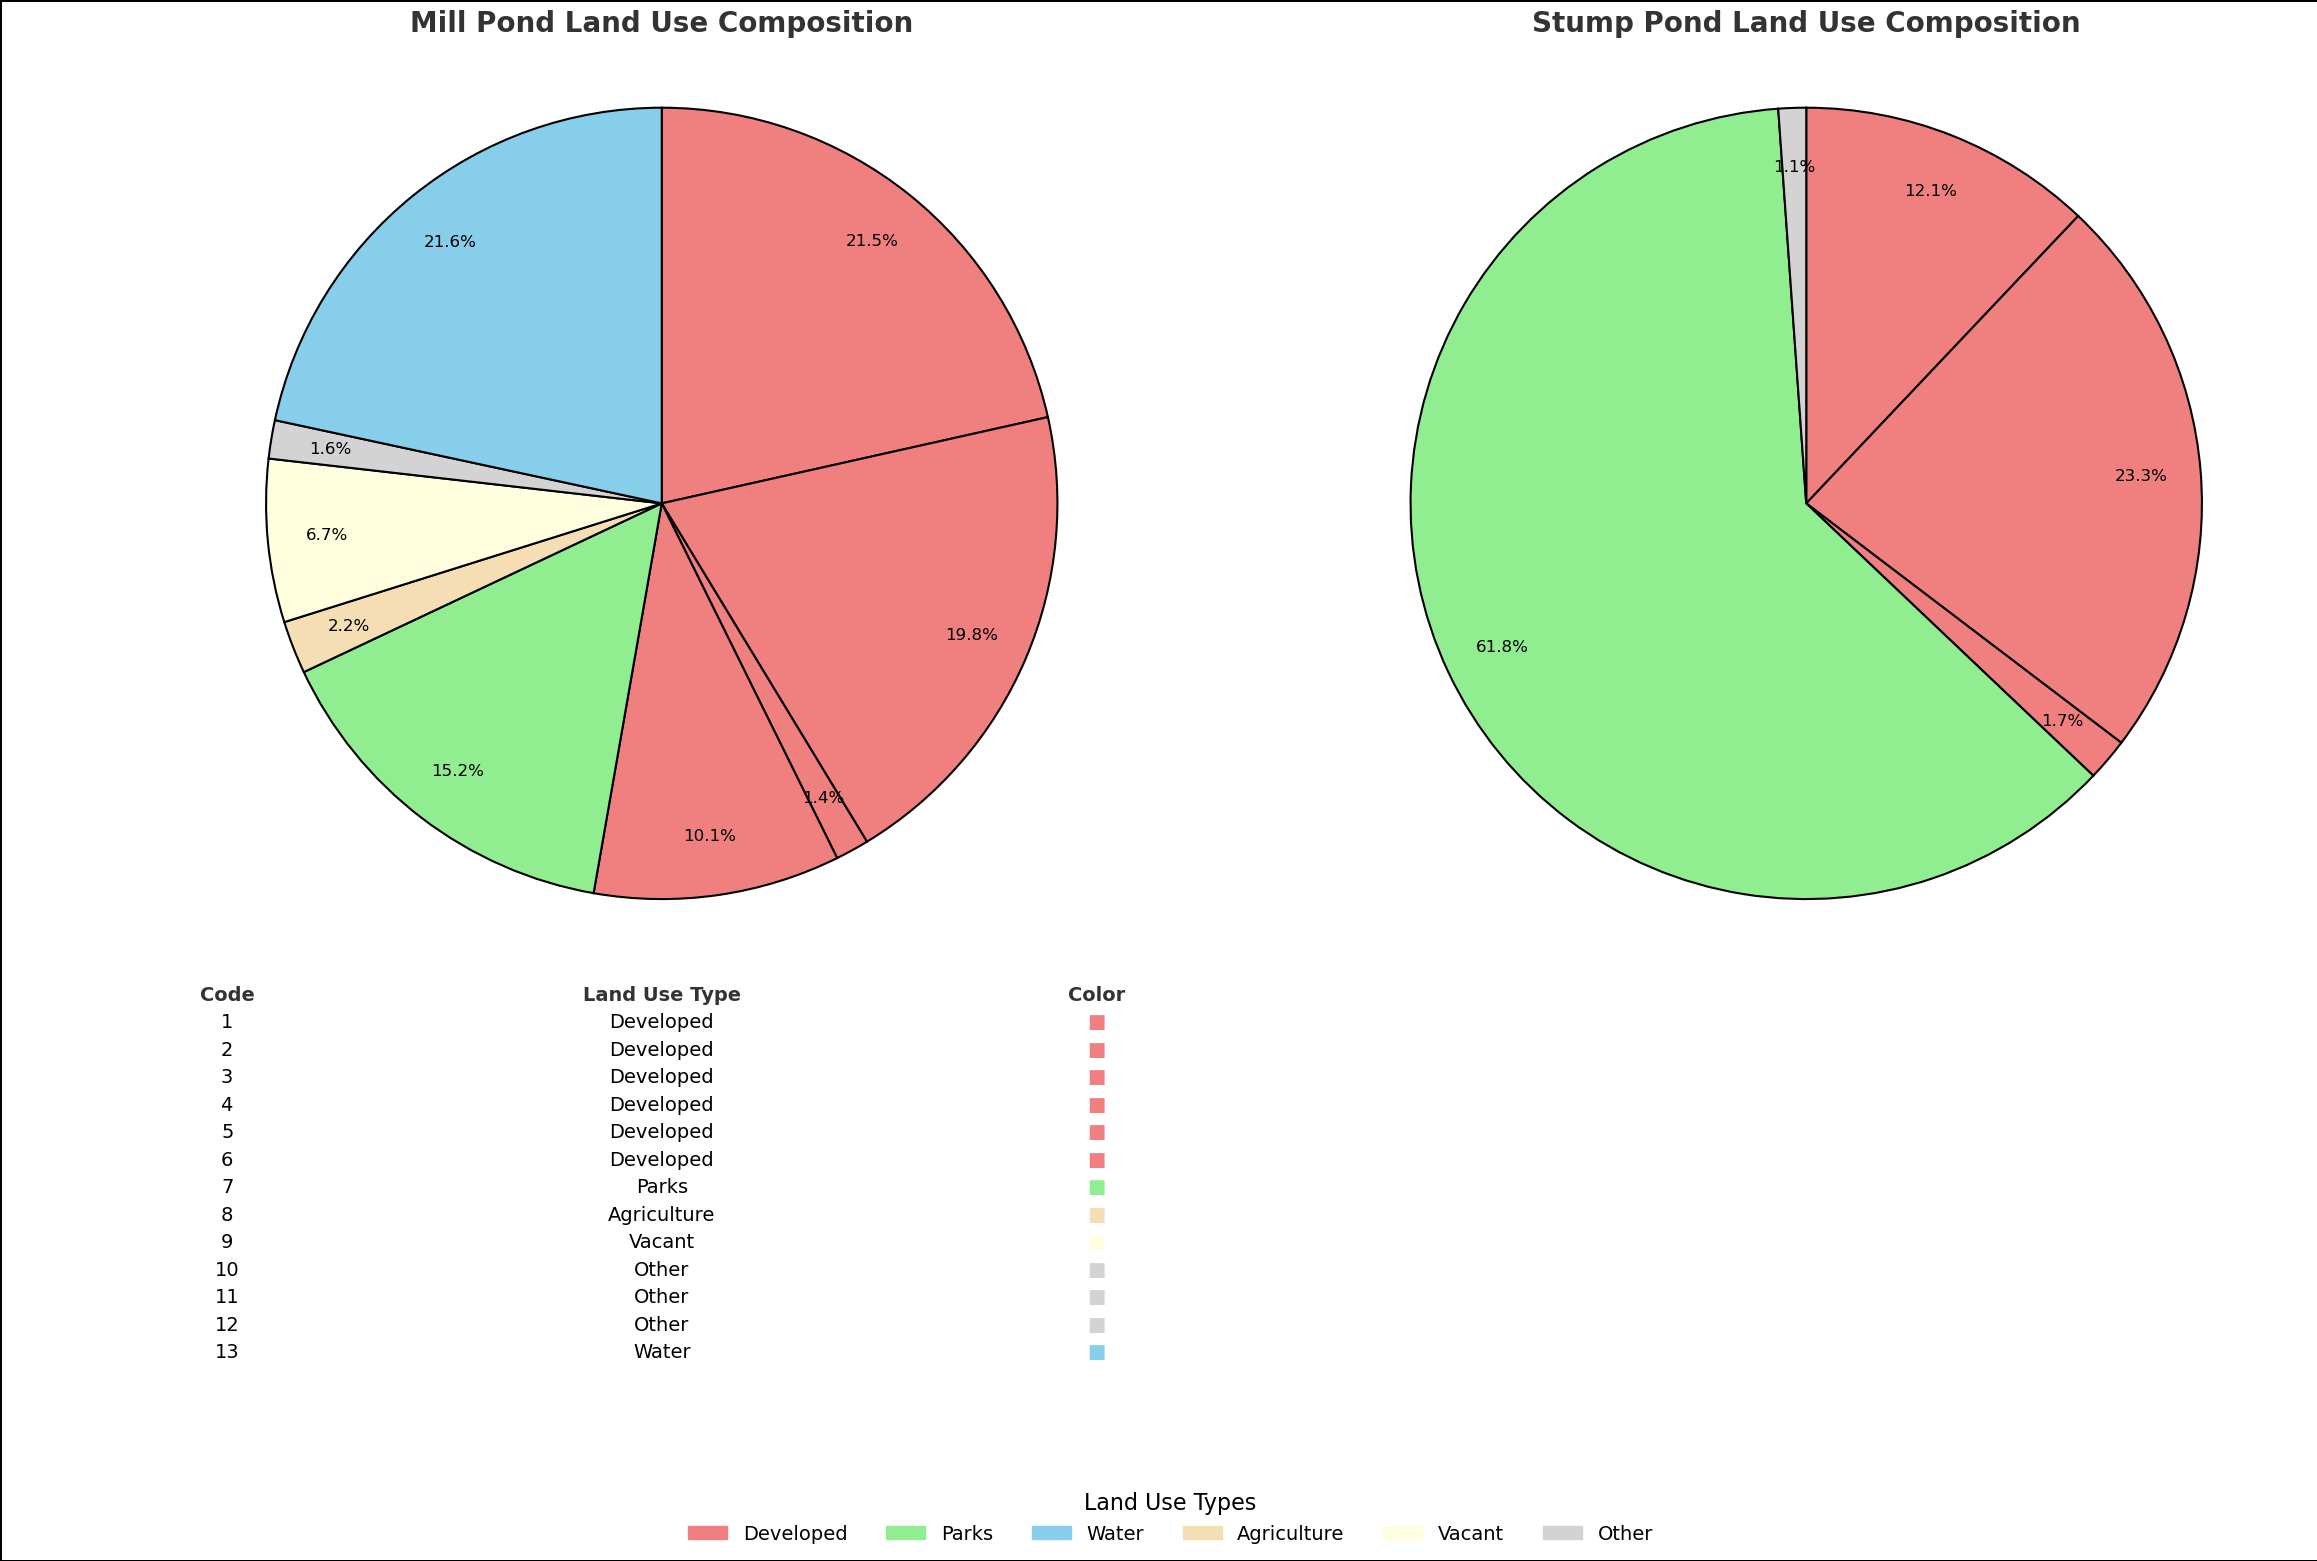

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from shapely.geometry import Point

land_use_mapping_codes = {
    '1': 'Developed',
    '2': 'Developed',
    '3': 'Developed',
    '4': 'Developed',
    '5': 'Developed',
    '6': 'Developed',
    '7': 'Parks',
    '8': 'Agriculture',
    '9': 'Vacant',
    '10': 'Other',
    '11': 'Other',
    '12': 'Other',
    '13': 'Water'
}


land_use_colors = {
    'Developed': 'lightcoral',
    'Parks': 'lightgreen',
    'Water': 'skyblue',
    'Agriculture': 'wheat',
    'Vacant': 'lightyellow',
    'Other': 'lightgray'
}

# ================================================================
# Section 1: Load Data
# ================================================================
def load_data():
    # Load towns shapefile
    try:
        towns = gpd.read_file(r"C:\Users\xrcru\OneDrive\Documents\Spring25\GeoComp1\Final Project\Data\SuffolkCounty_Towns\Town_Polygon.shp")
        census_tracts = gpd.read_file(r"C:\Users\xrcru\OneDrive\Documents\Spring25\GeoComp1\Final Project\Data\Census_Tract\Census_Tract.shp")
    except FileNotFoundError:
        print("Error: One or more data files not found. Please check the file paths.")
        return None, None

    # Reproject to EPSG:6538 (NAD83(2011) / New York Long Island)
    towns = towns.to_crs(epsg=6538)
    census_tracts = census_tracts.to_crs(epsg=6538)

    return towns, census_tracts

# ================================================================
# Section 2: Process Data
# ================================================================
def process_data(towns, census_tracts):
    if towns is None or census_tracts is None:
        return None

    # Clip census tracts to town boundaries
    census_tracts_clipped = gpd.clip(census_tracts, towns)

    # Calculate area in square kilometers and population density
    census_tracts_clipped['area_km2'] = census_tracts_clipped['ALAND'] / 10**6
    census_tracts_clipped['population_density'] = census_tracts_clipped['TOTALPOP'] / census_tracts_clipped['area_km2']
    census_tracts_clipped['population_density'] = census_tracts_clipped['population_density'].fillna(0)
    census_tracts_clipped['population_density'] = census_tracts_clipped['population_density'].replace([float('inf'), -float('inf')], 0)

    return census_tracts_clipped

# ================================================================
# Section 3: Load Dams Data
# ================================================================
def load_dams():
    try:
        dams = gpd.read_file(r"C:\Users\xrcru\OneDrive\Documents\Spring25\GeoComp1\Final Project\Data\SuffolkCountyDams\Clipped_Dams_Brookhaven_Smithtown.shp")
        return dams
    except FileNotFoundError:
        print("Error: Dams data file not found. Please check the file path.")
        return None

# ================================================================
# Section 4: Create Buffers for Mill Pond and Stump Pond
# ================================================================
def create_buffers(towns):
    if towns is None:
        return None, None

    # Define buffer distance (e.g., 1.5 km)
    buffer_distance = 1500  # in meters, adjust as needed

    # Mill Pond and Stump Pond coordinates (Longitude, Latitude)
    mill_pond = Point(-73.1475, 40.9149)
    stump_pond = Point(-73.2278, 40.8424)

    # Create GeoDataFrames for the points
    mill_pond_gdf = gpd.GeoDataFrame(geometry=[mill_pond], crs="EPSG:4326")
    stump_pond_gdf = gpd.GeoDataFrame(geometry=[stump_pond], crs="EPSG:4326")

    # Convert to the same CRS as your other data
    mill_pond_gdf = mill_pond_gdf.to_crs(towns.crs)
    stump_pond_gdf = stump_pond_gdf.to_crs(towns.crs)

    # Create buffers around the points
    mill_pond_buffer = mill_pond_gdf.buffer(buffer_distance)
    stump_pond_buffer = stump_pond_gdf.buffer(buffer_distance)

    # Create GeoDataFrames for the buffers
    mill_pond_buffer_gdf = gpd.GeoDataFrame(geometry=mill_pond_buffer, crs=towns.crs)
    stump_pond_buffer_gdf = gpd.GeoDataFrame(geometry=stump_pond_buffer, crs=towns.crs)

    return mill_pond_buffer_gdf, stump_pond_buffer_gdf

# ================================================================
# Section 5: Plotting the Map
# ================================================================
def plot_population_density_map(towns, census_tracts_clipped, dams, mill_pond_buffer_gdf, stump_pond_buffer_gdf):
    if towns is None or census_tracts_clipped is None:
        print("Error: Cannot plot map due to missing town or census data.")
        return
    if dams is None:
        print("Warning: Dams data not loaded, skipping dams layer.")
    if mill_pond_buffer_gdf is None or stump_pond_buffer_gdf is None:
        print("Warning: Buffer data not created, skipping buffer layers.")

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 12))

    # Plot the population density
    census_tracts_clipped.plot(
        column='population_density', ax=ax, legend=True,
        legend_kwds={'label': "Population Density (people per km²)", 'orientation': "horizontal"},
        cmap='YlGnBu', edgecolor='none'
    )

    # Plot town boundaries
    towns.boundary.plot(ax=ax, linewidth=1, color='black')

    # Plot the dams with updated icon (purple triangles), on top of all layers
    if dams is not None:
        dams.plot(
            ax=ax, color='purple', markersize=50, marker='^',  # Purple triangle markers
            label='Dams (Smithtown and Brookhaven)'
        )

    # Plot the Mill Pond and Stump Pond buffers with updated transparency, underneath the dams
    if mill_pond_buffer_gdf is not None:
        mill_pond_buffer_gdf.plot(ax=ax, color='blue', alpha=0.25, edgecolor='blue', label='Mill Pond 1.5 km Buffer')
    if stump_pond_buffer_gdf is not None:
        stump_pond_buffer_gdf.plot(ax=ax, color='red', alpha=0.25, edgecolor='red', label='Stump Pond 1.5 km Buffer')

    # Title and aesthetic clean-up
    ax.set_title('2020 Suffolk County Population Density Map with Buffers and Dams', fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Add legend if there are multiple layers
    if dams is not None or mill_pond_buffer_gdf is not None or stump_pond_buffer_gdf is not None:
        # Create custom legend handles for the buffers
        buffer_handles = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Mill Pond 1.5 km Buffer'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Stump Pond 1.5 km Buffer')
        ]

        # Create custom legend handle for dams
        dam_handle = Line2D([0], [0], marker='^', color='w', markerfacecolor='purple', markersize=10, label='Dams (Smithtown and Brookhaven)')

        # Get existing handles and labels
        handles, labels = ax.get_legend_handles_labels()

        # Extend with new handles and labels
        handles.extend(buffer_handles)
        labels.extend([handle.get_label() for handle in buffer_handles])
        handles.append(dam_handle)
        labels.append(dam_handle.get_label())

        # Remove duplicates
        unique_labels = dict(zip(labels, handles))  # Remove duplicate labels
        ax.legend(unique_labels.values(), unique_labels.keys(), loc='upper right')

    # Display the map
    plt.tight_layout()
    plt.show()

# ================================================================
# Section 6: Population Buffer Analysis
# ================================================================
def analyze_population_in_buffers(census_tracts_clipped, mill_pond_buffer_gdf, stump_pond_buffer_gdf):
    if census_tracts_clipped is None or mill_pond_buffer_gdf is None or stump_pond_buffer_gdf is None:
        print("Error: Cannot analyze population due to missing data.")
        return None, None, None, None

    # Clip census tracts to each pond's buffer
    mill_pond_population = gpd.clip(census_tracts_clipped, mill_pond_buffer_gdf)
    stump_pond_population = gpd.clip(census_tracts_clipped, stump_pond_buffer_gdf)

    # Calculate total population within each buffer
    mill_pond_total_population = mill_pond_population['TOTALPOP'].sum()
    stump_pond_total_population = stump_pond_population['TOTALPOP'].sum()

    # Calculate area of clipped tracts within each buffer (in km²)
    mill_pond_population['area_km2'] = mill_pond_population['geometry'].area / 10**6
    stump_pond_population['area_km2'] = stump_pond_population['geometry'].area / 10**6

    # Calculate overall population density inside each buffer
    mill_pond_density = mill_pond_total_population / mill_pond_population['area_km2'].sum()
    stump_pond_density = stump_pond_total_population / stump_pond_population['area_km2'].sum()

    print("===== Population Buffer Analysis Summary =====")
    print(f"Mill Pond Buffer:")
    print(f"  Total Population: {mill_pond_total_population}")
    print(f"  Population Density: {mill_pond_density:.2f} people/km²\n")

    print(f"Stump Pond Buffer:")
    print(f"  Total Population: {stump_pond_total_population}")
    print(f"  Population Density: {stump_pond_density:.2f} people/km²")
    print("===============================================")

    return mill_pond_total_population, stump_pond_total_population, mill_pond_density, stump_pond_density

# ================================================================
# Section 7: Plot Population Bar Chart
# ================================================================
def plot_population_bar_chart(mill_pond_population, stump_pond_population):
    if mill_pond_population is None or stump_pond_population is None:
        print("Error: Cannot plot population bar chart due to missing population data.")
        return

    fig, ax = plt.subplots(figsize=(8, 6))
    ponds = ['Mill Pond', 'Stump Pond']
    populations = [mill_pond_population, stump_pond_population]

    # Create bars for population
    bars = ax.bar(ponds, populations, color=['blue', 'red'], alpha=0.7)

    # Add population labels above bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10, fontweight='bold')

    ax.set_ylabel('Total Population')
    ax.set_title('Total Population within 1.5 km Buffers of Mill Pond and Stump Pond')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# ================================================================
# Section 8: Load Land Use 2016 Data
# ================================================================
def load_land_use_data():
    try:
        land_use_2016 = gpd.read_file(r"C:\Users\xrcru\OneDrive\Documents\Spring25\GeoComp1\Final Project\Data\Land_Use_2016_Polygon\Land_Use_2016_Polygon.shp")
        print("Original CRS of land_use_2016:", land_use_2016.crs)
        # Reproject to EPSG:6538 to match the buffers
        land_use_2016 = land_use_2016.to_crs(epsg=6538)
        print("CRS of land_use_2016 after reprojection:", land_use_2016.crs)
        return land_use_2016
    except FileNotFoundError:
        print("Error: Land Use 2016 data file not found.")
        return None

# ================================================================
# Section 9: Clip Land Use Data to Buffers
# ================================================================
def clip_land_use_to_buffers(land_use_2016, mill_pond_buffer_gdf, stump_pond_buffer_gdf):
    if land_use_2016 is None or mill_pond_buffer_gdf is None or stump_pond_buffer_gdf is None:
        print("Error: Cannot clip land use data due to missing data.")
        return None, None
    land_use_mill_pond = gpd.clip(land_use_2016, mill_pond_buffer_gdf)
    land_use_stump_pond = gpd.clip(land_use_2016, stump_pond_buffer_gdf)
    print("Mill Pond Land Use Data:")
    print(land_use_mill_pond.head())
    print("Stump Pond Land Use Data:")
    print(land_use_stump_pond.head())
    return land_use_mill_pond, land_use_stump_pond

# ================================================================
# Section 10: Land Use Statistics Calculation
# ================================================================
def calculate_land_use_stats(gdf, land_use_mapping_codes):
    """Calculates land use area and percentage for a given GeoDataFrame."""
    if gdf is None or gdf.empty:
        return pd.Series(), pd.Series()

    # 1. Calculate Area (in square kilometers)
    gdf['area_km2'] = gdf.geometry.area / 10**6

    # 2. Group by Land Use Code and Sum Area
    land_use_area = gdf.groupby('SCLANDUSE')['area_km2'].sum()

    # 3. Calculate Total Area
    total_area = land_use_area.sum()

    # 4. Calculate Percentage
    land_use_pct = (land_use_area / total_area) * 100

    # 5. Ensure all mapping codes are present and handle missing values
    land_use_pct = land_use_pct.reindex(list(land_use_mapping_codes.keys()), fill_value=0).fillna(0)
    land_use_area = land_use_area.reindex(list(land_use_mapping_codes.keys()), fill_value=0).fillna(0).round(2)

    return land_use_pct, land_use_area

# ================================================================
# Section 10: Analyze and Plot Land Use Pie Charts with Table (Appealing & Final Touches)
# ================================================================
def analyze_and_plot_land_use(land_use_mill_pond, land_use_stump_pond, land_use_colors, land_use_mapping_codes):
    if land_use_mill_pond is None or land_use_stump_pond is None:
        print("Error: Cannot analyze or plot land use due to missing data.")
        return

    fig, axs = plt.subplots(2, 2, figsize=(24, 18), gridspec_kw={'height_ratios': [1, 0.4]}, facecolor='white', edgecolor='black', linewidth=2)
    axs_pie = axs[0, :]
    ax_table = axs[1, 0]
    fig.patch.set_facecolor('white') # Ensure figure background is white

    # --- Appealing Pie Charts ---
    for i, (title, gdf) in enumerate(zip(['Mill Pond', 'Stump Pond'], [land_use_mill_pond, land_use_stump_pond])):
        # Calculate the area of each land use polygon within the buffer
        gdf['area'] = gdf.geometry.area
        land_use_area = gdf.groupby('SCLANDUSE')['area'].sum()
        total_area = land_use_area.sum()
        land_use_pct = (land_use_area / total_area) * 100
        land_use_pct = land_use_pct[land_use_pct > 1] # Filter out very small percentages for clarity

        # Map the 'SCLANDUSE' codes to your land use names and colors
        labels = [land_use_mapping_codes.get(str(code), f'Unknown ({code})') for code in land_use_pct.index]
        colors = [land_use_colors.get(land_use_mapping_codes.get(str(code)), 'gray') for code in land_use_pct.index]

        # Plotting Pie with better aesthetics
        wedges, texts, autotexts = axs_pie[i].pie(
            land_use_pct,
            labels=None, # Don't show labels on the pie itself
            colors=colors,
            startangle=90,
            counterclock=False,
            autopct='%1.1f%%',
            textprops={'fontsize': 12, 'color': 'black'},
            wedgeprops={'edgecolor': 'black', 'linewidth': 1.5, 'antialiased': True}, # Black border for slices
            pctdistance=0.85
        )
        axs_pie[i].set_title(f'{title} Land Use Composition', fontsize=20, fontweight='bold', color='#333333')
        axs_pie[i].axis('equal')
        axs_pie[i].set_facecolor('white') # White background for each subplot
        axs_pie[i].spines['top'].set_edgecolor('black')
        axs_pie[i].spines['bottom'].set_edgecolor('black')
        axs_pie[i].spines['left'].set_edgecolor('black')
        axs_pie[i].spines['right'].set_edgecolor('black')

    # Create a more visually appealing legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=land_use_colors.get(label, 'gray'), edgecolor='black') for label in land_use_colors]
    labels_legend = list(land_use_colors.keys())
    fig.legend(handles, labels_legend, loc='lower center', bbox_to_anchor=(0.5, 0.05), ncol=len(land_use_colors),
               fontsize=14, frameon=False, title='Land Use Types', title_fontsize=16)

    # --- Appealing Table ---
    land_use_table_data = []
    for code, name in land_use_mapping_codes.items():
        color = land_use_colors.get(name, 'gray')
        land_use_table_data.append([code, name, f'■']) # Just the square

    table = ax_table.table(
        cellText=land_use_table_data,
        colLabels=['Code', 'Land Use Type', 'Color'],
        cellLoc='center',
        loc='center',
        edges='open'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1.3, 1.6)

    # Style the table cells and header
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_text_props(weight='bold', color='#333333')
            cell.set_facecolor('#dddddd')
        elif col == 2 and row > 0: # Color the 'Color' column
            land_use_name = land_use_mapping_codes.get(land_use_table_data[row - 1][0])
            color = land_use_colors.get(land_use_name, 'gray')
            cell.set_facecolor(color)
            cell.set_text_props(color=color) # Make the text the same color as the background
        else:
            cell.set_facecolor('white')
        cell.set_edgecolor('black') # Black cell borders

    # Hide the axes for the table subplot
    ax_table.axis('off')
    axs[1, 1].axis('off')

    plt.tight_layout(rect=[0.02, 0.15, 0.98, 0.92]) # Adjust layout with padding
    plt.show()



if __name__ == "__main__":
    towns_data, census_data = load_data()
    if towns_data is not None and census_data is not None:
        census_clipped = process_data(towns_data, census_data)
        dams_data = load_dams()
        mill_pond_buffer, stump_pond_buffer = create_buffers(towns_data)
        plot_population_density_map(towns_data, census_clipped, dams_data, mill_pond_buffer, stump_pond_buffer)
        mill_pond_pop, stump_pond_pop, _, _ = analyze_population_in_buffers(census_clipped, mill_pond_buffer, stump_pond_buffer)
        plot_population_bar_chart(mill_pond_pop, stump_pond_pop)
        land_use_2016_data = load_land_use_data()
        if land_use_2016_data is not None:
            land_use_mill_pond_clipped, land_use_stump_pond_clipped = clip_land_use_to_buffers(land_use_2016_data, mill_pond_buffer, stump_pond_buffer)
            analyze_and_plot_land_use(land_use_mill_pond_clipped, land_use_stump_pond_clipped, land_use_colors, land_use_mapping_codes) # Pass the mapping codes

In [64]:
# ================================================================
# Section: Reproject Land Use Layer and Redo Intersection
# ================================================================

# Reproject land use layer to match buffers (EPSG:6538)
land_use_all = land_use_all.to_crs(epsg=6538)

# Redo intersection using matching CRS
land_use_mill_pond = land_use_all[land_use_all.intersects(mill_pond_buffer.union_all())].copy()
land_use_stump_pond = land_use_all[land_use_all.intersects(stump_pond_buffer.union_all())].copy()

# Map land use codes to descriptions
land_use_mapping = {
    1: 'Developed',
    2: 'Developed',
    3: 'Developed',
    4: 'Developed',
    5: 'Developed',
    6: 'Developed',
    7: 'Parks',
    8: 'Agriculture',
    9: 'Vacant',
    10: 'Other',
    11: 'Other',
    12: 'Other',
    13: 'Water'
}

# Apply land use mapping
land_use_mill_pond.loc[:, 'LandUse'] = land_use_mill_pond['SCLANDUSE'].map(land_use_mapping)
land_use_stump_pond.loc[:, 'LandUse'] = land_use_stump_pond['SCLANDUSE'].map(land_use_mapping)

# Handle any NaN values (missing values after mapping) by filling with 'Unknown'
land_use_mill_pond.loc[:, 'LandUse'] = land_use_mill_pond['LandUse'].fillna('Unknown')
land_use_stump_pond.loc[:, 'LandUse'] = land_use_stump_pond['LandUse'].fillna('Unknown')

# Count parcels by Land Use
mill_pond_parcel_counts = land_use_mill_pond['LandUse'].value_counts().sort_values(ascending=False)
stump_pond_parcel_counts = land_use_stump_pond['LandUse'].value_counts().sort_values(ascending=False)

# Display results
print("Mill Pond Parcel Counts:\n", mill_pond_parcel_counts)
print("\nStump Pond Parcel Counts:\n", stump_pond_parcel_counts)



Mill Pond Parcel Counts:
 LandUse
Developed      1043
Vacant           77
Parks            66
Other            26
Water             9
Agriculture       5
Name: count, dtype: int64

Stump Pond Parcel Counts:
 LandUse
Developed    994
Parks         22
Vacant        16
Other         15
Name: count, dtype: int64


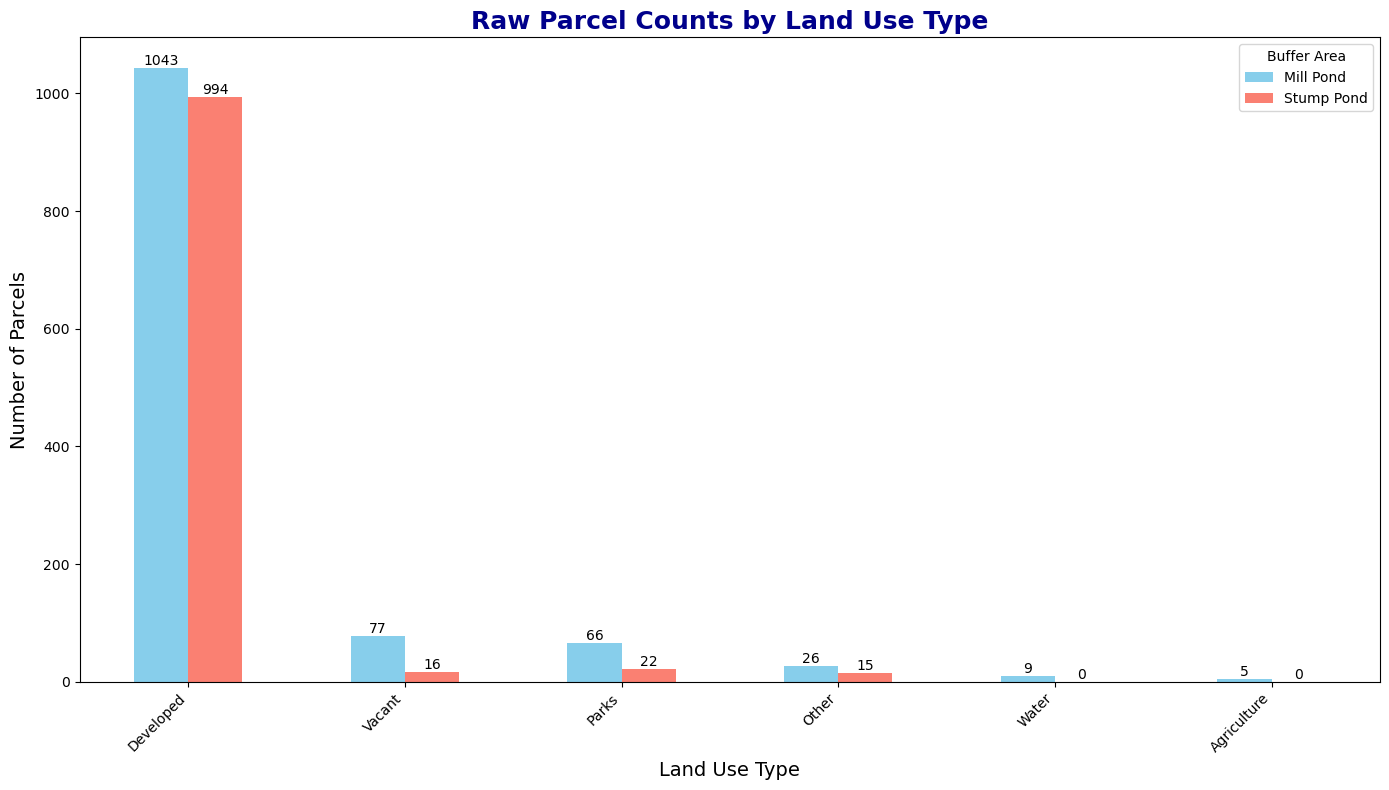

In [63]:
# ================================================================
# Section: Plot Raw Parcel Counts as Bar Charts
# ================================================================

# Combine counts into a single DataFrame for comparison
parcel_count_df = pd.DataFrame({
    'Mill Pond': mill_pond_parcel_counts,
    'Stump Pond': stump_pond_parcel_counts
}).fillna(0).astype(int)

# Sort by total combined count for visual clarity
parcel_count_df['Total'] = parcel_count_df['Mill Pond'] + parcel_count_df['Stump Pond']
parcel_count_df = parcel_count_df.sort_values(by='Total', ascending=False).drop(columns='Total')

# Plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 8))

parcel_count_df.plot(kind='bar', ax=ax, color=['skyblue', 'salmon'])
ax.set_title('Raw Parcel Counts by Land Use Type', fontsize=18, fontweight='bold', color='darkblue')
ax.set_xlabel('Land Use Type', fontsize=14)
ax.set_ylabel('Number of Parcels', fontsize=14)
ax.set_xticklabels(parcel_count_df.index, rotation=45, ha='right')
ax.legend(title='Buffer Area')

# Add value labels to each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10)

plt.tight_layout()
plt.show()